In [1]:
import numpy as np
import pandas as pd
import pickle

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [11]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau_comp_time\\trials\\'

fig_folder = results_folder
save_fig = True

In [3]:
def get_compute_time_df(trial_dict_, n_trials_, method_, alphas_, fr_values_, taus_ms_, n_iteration_=None, bin_size_=50):
    records = []
    for unit_id, data in trial_dict_.items():
        elapsed_time_acf = data['elapsed_time_acf']
        elapsed_time_tau_fit = data['elapsed_time_tau_fit']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(elapsed_time_acf[idx], elapsed_time_tau_fit[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(elapsed_time_acf, elapsed_time_tau_fit)

        for time_acf, time_fit in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'elapsed_time_acf_sec': time_acf,
                'elapsed_time_tau_fit_sec': time_fit,
                'method': method_,
            })

    compute_time_df = pd.DataFrame.from_records(records)
    compute_time_df['n_trials'] = n_trials_
    compute_time_df['bin_size'] = bin_size_
    compute_time_df['fr'] = fr_values_
    compute_time_df['alpha'] = alphas_
    compute_time_df['tau_ms_true'] = taus_ms_

    nan_count = compute_time_df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return compute_time_df

In [4]:
with open(dataset_folder + 'spike_trains.pkl', 'rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms [600000 600000 600000 ... 600000 600000 600000]


In [5]:
with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)
pearsontr_trial_avg_plot_df = get_compute_time_df(pearsonr_trial_avg_dict, 40, 'pearsonr_trial_avg', alphas, fr_values, taus_ms, random_trials_impl)
sttc_trial_concat_plot_df = get_compute_time_df(sttc_trial_concat_dict, 40, 'sttc_trial_concat', alphas, fr_values, taus_ms, random_trials_impl)

# acf_tau_full_df = get_compute_time_df(acf_full_dict, 600, 'acf_full', alphas, fr_values, taus_ms, bin_size_=50)
# isttc_tau_full_df = get_compute_time_df(isttc_full_dict, 600, 'isttc_full', alphas, fr_values, taus_ms, bin_size_=50)

tau_all_long_df = pd.concat([pearsontr_trial_avg_plot_df, sttc_trial_concat_plot_df])
tau_all_long_df.reset_index(inplace=True, drop=True)
tau_all_long_df['total_time_sec'] = tau_all_long_df['elapsed_time_tau_fit_sec'] + tau_all_long_df['elapsed_time_acf_sec']
tau_all_long_df['elapsed_time_tau_fit_sec_log10'] = np.log10(tau_all_long_df['elapsed_time_tau_fit_sec'])
tau_all_long_df['elapsed_time_acf_sec_log10'] = np.log10(tau_all_long_df['elapsed_time_acf_sec'])
tau_all_long_df['total_time_sec_log10'] = np.log10(tau_all_long_df['total_time_sec'])

tau_all_long_df.to_csv(results_folder + 'compute_time_trials_long_df_all_units.csv')
tau_all_long_df.to_pickle(results_folder + 'compute_time_trials_long_df_all_units.pkl')

tau_all_long_df

,unit_id,elapsed_time_acf_sec,elapsed_time_tau_fit_sec,method,n_trials,bin_size,fr,alpha,tau_ms_true,total_time_sec,elapsed_time_tau_fit_sec_log10,elapsed_time_acf_sec_log10,total_time_sec_log10
0,0,0.048576,0.005101,pearsonr_trial_avg,40,50,7.741821,0.851099,150.923515,0.053677,-2.292328,-1.313580,-1.270212
1,1,0.043343,0.003654,pearsonr_trial_avg,40,50,4.394396,0.858098,147.947233,0.046997,-2.437279,-1.363078,-1.327931
2,2,0.045443,0.011923,pearsonr_trial_avg,40,50,8.587393,0.528805,267.002290,0.057366,-1.923618,-1.342530,-1.241344
3,3,0.048585,0.006260,pearsonr_trial_avg,40,50,6.976707,0.300692,194.403797,0.054845,-2.203405,-1.313499,-1.260861
4,4,0.040702,0.008346,pearsonr_trial_avg,40,50,0.950832,0.691458,239.986489,0.049048,-2.078511,-1.390387,-1.309380
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,99995,0.023428,0.007247,sttc_trial_concat,40,50,2.672839,0.244627,125.243251,0.030675,-2.139854,-1.630259,-1.513214
199996,99996,0.030222,0.004533,sttc_trial_concat,40,50,5.754497,0.596987,94.481295,0.034755,-2.343595,-1.519674,-1.458978
199997,99997,0.032500,0.008541,sttc_trial_concat,40,50,5.604441,0.258915,174.189672,0.041042,-2.068481,-1.488111,-1.386776
199998,99998,0.014586,0.131046,sttc_trial_concat,40,50,1.219057,0.187620,76.565797,0.145632,-0.882576,-1.836064,-0.836743


In [ ]:
with open(results_folder + 'var_trials\\pearsonr_trial_avg_50ms_dict_60.pkl', "rb") as f:
    pearsonr_trial_avg_dict_60 = pickle.load(f)

with open(results_folder + 'var_trials\\pearsonr_trial_avg_50ms_dict_80.pkl', "rb") as f:
    pearsonr_trial_avg_dict_80 = pickle.load(f)

with open(results_folder + 'var_trials\\pearsonr_trial_avg_50ms_dict_100.pkl', "rb") as f:
    pearsonr_trial_avg_dict_100 = pickle.load(f)


with open(results_folder + 'var_trials\\sttc_trial_concat_50ms_dict_60.pkl', "rb") as f:
    sttc_trial_concat_dict_60 = pickle.load(f)

with open(results_folder + 'var_trials\\sttc_trial_concat_50ms_dict_80.pkl', "rb") as f:
    sttc_trial_concat_dict_80 = pickle.load(f)

with open(results_folder + 'var_trials\\sttc_trial_concat_50ms_dict_100.pkl', "rb") as f:
    sttc_trial_concat_dict_100 = pickle.load(f)

random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_avg_plot_df_60 = get_compute_time_df(pearsonr_trial_avg_dict_60, 60, 'pearsonr_trial_avg', 
                                                     alphas[:1000], fr_values[:1000], taus_ms[:1000], random_trials_impl)
pearsontr_trial_avg_plot_df_80 = get_compute_time_df(pearsonr_trial_avg_dict_80, 80, 'pearsonr_trial_avg', 
                                                     alphas[:1000], fr_values[:1000], taus_ms[:1000], random_trials_impl)
pearsontr_trial_avg_plot_df_100 = get_compute_time_df(pearsonr_trial_avg_dict_100, 100, 'pearsonr_trial_avg', 
                                                     alphas[:1000], fr_values[:1000], taus_ms[:1000], random_trials_impl)

sttc_trial_concat_plot_df_60 = get_compute_time_df(sttc_trial_concat_dict_60, 60, 'sttc_trial_concat', 
                                                   alphas[:1000], fr_values[:1000], taus_ms[:1000], random_trials_impl)
sttc_trial_concat_plot_df_80 = get_compute_time_df(sttc_trial_concat_dict_80, 80, 'sttc_trial_concat', 
                                                   alphas[:1000], fr_values[:1000], taus_ms[:1000], random_trials_impl)
sttc_trial_concat_plot_df_100 = get_compute_time_df(sttc_trial_concat_dict_80, 80, 'sttc_trial_concat', 
                                                   alphas[:1000], fr_values[:1000], taus_ms[:1000], random_trials_impl)

tau_all_long_len_df = pd.concat([pearsontr_trial_avg_plot_df_60, pearsontr_trial_avg_plot_df_80, pearsontr_trial_avg_plot_df_100, 
                            sttc_trial_concat_plot_df_60, sttc_trial_concat_plot_df_80, sttc_trial_concat_plot_df_100])
tau_all_long_len_df.reset_index(inplace=True, drop=True)
tau_all_long_len_df['total_time_sec'] = tau_all_long_df['elapsed_time_tau_fit_sec'] + tau_all_long_len_df['elapsed_time_acf_sec']
tau_all_long_len_df['elapsed_time_tau_fit_sec_log10'] = np.log10(tau_all_long_len_df['elapsed_time_tau_fit_sec'])
tau_all_long_len_df['elapsed_time_acf_sec_log10'] = np.log10(tau_all_long_len_df['elapsed_time_acf_sec'])
tau_all_long_len_df['total_time_sec_log10'] = np.log10(tau_all_long_len_df['total_time_sec'])

tau_all_long_len_df = pd.concat([tau_all_long_len_df, tau_all_long_df.query('unit_id < 1000').copy()])
tau_all_long_len_df.reset_index(inplace=True, drop=True)

tau_all_long_len_df.to_csv(results_folder + 'var_trials\\compute_time_trials_long_df_1000_units.csv')
tau_all_long_len_df.to_pickle(results_folder + 'var_trials\\compute_time_trials_long_df_1000_units.pkl')

tau_all_long_len_df

In [ ]:
# # to do when run finished
# results_folder_abctau = r"D:\all_abctau_dst_gamma_0_01_50_comp_time\\"
# with open('D:\\all_abctau_dst_gamma_0_01_50_comp_time\\comp_time\\elapsed_time_spike_train_0.pkl', "rb") as f:
#     unit_time_dict = pickle.load(f)

# unit_time_dict

### Extra dfs for plotting

In [6]:
tau_all_long_df_subset = tau_all_long_df[['unit_id', 'method', 'total_time_sec']].copy()
tau_all_long_df_subset

,unit_id,method,total_time_sec
0,0,pearsonr_trial_avg,0.053677
1,1,pearsonr_trial_avg,0.046997
2,2,pearsonr_trial_avg,0.057366
3,3,pearsonr_trial_avg,0.054845
4,4,pearsonr_trial_avg,0.049048
...,...,...,...
199995,99995,sttc_trial_concat,0.030675
199996,99996,sttc_trial_concat,0.034755
199997,99997,sttc_trial_concat,0.041042
199998,99998,sttc_trial_concat,0.145632


In [7]:
thresholds = [100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 100000]
n_reps = 100   # number of repetitions

rows = []

for n in thresholds:
    for method, df_method in tau_all_long_df_subset.groupby("method"):
        units = df_method["unit_id"].unique()

        # run repeated sampling
        total_sec_list = []
        for _ in range(n_reps):
            sampled_units = np.random.choice(units, size=n, replace=False)
            df_sample = df_method[df_method.unit_id.isin(sampled_units)]
            total_sec_list.append(df_sample["total_time_sec"].sum())

        # median across repetitions
        rows.append({
            "method": method,
            "n_units": n,
            "median_total_time_sec": np.median(total_sec_list)
        })

result_df = pd.DataFrame(rows)
result_df["median_total_time_min"] = result_df["median_total_time_sec"] / 60
result_df["median_total_time_h"] = result_df["median_total_time_min"] / 60

result_df


,method,n_units,median_total_time_sec,median_total_time_min,median_total_time_h
0,pearsonr_trial_avg,100,7.059311,0.117655,0.001961
1,sttc_trial_concat,100,5.677928,0.094632,0.001577
2,pearsonr_trial_avg,200,14.069323,0.234489,0.003908
3,sttc_trial_concat,200,11.007551,0.183459,0.003058
4,pearsonr_trial_avg,300,21.302994,0.355050,0.005917
5,sttc_trial_concat,300,16.591493,0.276525,0.004609
6,pearsonr_trial_avg,400,28.336302,0.472272,0.007871
7,sttc_trial_concat,400,22.053637,0.367561,0.006126
8,pearsonr_trial_avg,500,35.482687,0.591378,0.009856
9,sttc_trial_concat,500,27.911047,0.465184,0.007753


### Plots

In [8]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

colors_full = [color_pearson_trail_avg, color_sttc_trail_concat]

               method  elapsed_time_acf_sec  elapsed_time_tau_fit_sec  \
0  pearsonr_trial_avg           4917.914342               2332.099676   
1   sttc_trial_concat           2931.343045               4092.527962   

   total_time_sec  total_time_min  total_time_h  
0     7250.014018      120.833567      2.013893  
1     7023.871007      117.064517      1.951075  


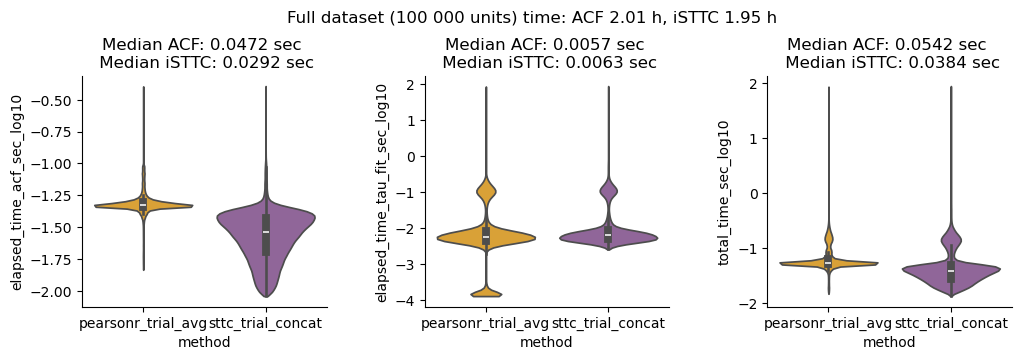

In [9]:
total_time_df = tau_all_long_df.groupby(by='method', as_index=False)[['elapsed_time_acf_sec', 'elapsed_time_tau_fit_sec', 'total_time_sec']].sum()
total_time_df['total_time_min'] = total_time_df['total_time_sec'] / 60
total_time_df['total_time_h'] = total_time_df['total_time_min'] / 60

print(total_time_df)


fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(x='method', y='elapsed_time_acf_sec_log10', hue='method',
               palette=colors_full, data=tau_all_long_df , cut=0, ax=axes[0])
axes[0].set_title(f"Median ACF: {tau_all_long_df.groupby('method')['elapsed_time_acf_sec'].median()['pearsonr_trial_avg']:.4f} sec \n Median iSTTC: {tau_all_long_df.groupby('method')['elapsed_time_acf_sec'].median()['sttc_trial_concat']:.4f} sec")

sns.violinplot(x='method', y='elapsed_time_tau_fit_sec_log10', hue='method',
               palette=colors_full, data=tau_all_long_df , cut=0, ax=axes[1])
axes[1].set_title(f"Median ACF: {tau_all_long_df.groupby('method')['elapsed_time_tau_fit_sec'].median()['pearsonr_trial_avg']:.4f} sec \n Median iSTTC: {tau_all_long_df.groupby('method')['elapsed_time_tau_fit_sec'].median()['sttc_trial_concat']:.4f} sec")

sns.violinplot(x='method', y='total_time_sec_log10', hue='method',
               palette=colors_full, data=tau_all_long_df , cut=0, ax=axes[2])
axes[2].set_title(f"Median ACF: {tau_all_long_df.groupby('method')['total_time_sec'].median()['pearsonr_trial_avg']:.4f} sec \n Median iSTTC: {tau_all_long_df.groupby('method')['total_time_sec'].median()['sttc_trial_concat']:.4f} sec")

for ax in axes.flat:
    sns.despine(ax=ax)

fig.suptitle(f'Full dataset (100 000 units) time: ACF {total_time_df.query('method == "pearsonr_trial_avg"')['total_time_h'].values[0]:.2f} h, iSTTC {total_time_df.query('method == "sttc_trial_concat"')['total_time_h'].values[0]:.2f} h', y=1.1)
    
#axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'trials_signal_comp_time.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'trials_signal_comp_time.svg' , bbox_inches='tight')

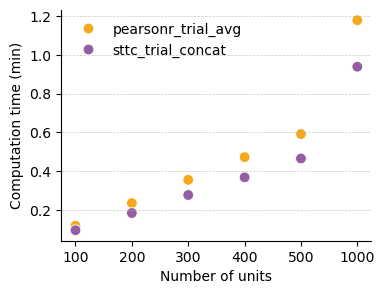

In [12]:
fig, axes = plt.subplots(1,1, figsize=(4,3))

sns.scatterplot(x=result_df['n_units'].astype(str), y='median_total_time_min', hue='method', 
                data=result_df[result_df['n_units'] <= 1000], palette=colors_full, s=60)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.legend(frameon=False)
#axes.set_ylim([-0.5, 5])
axes.set_xlabel('Number of units')
axes.set_ylabel('Computation time (min)')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'trials_comp_time_n_units.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'trials_comp_time_n_units.svg' , bbox_inches='tight')